# Facial Keypoints Detection

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Read the data

In [5]:
train = pd.read_csv("./data/training.csv")
test = pd.read_csv("./data/test.csv")
lookup = pd.read_csv("./data/IdLookupTable.csv")
sample = pd.read_csv("./data/SampleSubmission.csv")

In [6]:
print("Train data length = ", len(train))
print("Test data length = ", len(test))

Train data length =  7049
Test data length =  1783


# Check for nulls and split into good data and bad data

In [16]:
# check for null values
print(f"Feature \t\t\t Missing \t Percentage\n")
for k, v in train.isna().sum().items():
    print(f"{k !s:30} :{v :8} \t {round(v/len(train), 2)}%")

Feature 			 Missing 	 Percentage

left_eye_center_x              :      10 	 0.0%
left_eye_center_y              :      10 	 0.0%
right_eye_center_x             :      13 	 0.0%
right_eye_center_y             :      13 	 0.0%
left_eye_inner_corner_x        :    4778 	 0.68%
left_eye_inner_corner_y        :    4778 	 0.68%
left_eye_outer_corner_x        :    4782 	 0.68%
left_eye_outer_corner_y        :    4782 	 0.68%
right_eye_inner_corner_x       :    4781 	 0.68%
right_eye_inner_corner_y       :    4781 	 0.68%
right_eye_outer_corner_x       :    4781 	 0.68%
right_eye_outer_corner_y       :    4781 	 0.68%
left_eyebrow_inner_end_x       :    4779 	 0.68%
left_eyebrow_inner_end_y       :    4779 	 0.68%
left_eyebrow_outer_end_x       :    4824 	 0.68%
left_eyebrow_outer_end_y       :    4824 	 0.68%
right_eyebrow_inner_end_x      :    4779 	 0.68%
right_eyebrow_inner_end_y      :    4779 	 0.68%
right_eyebrow_outer_end_x      :    4813 	 0.68%
right_eyebrow_outer_end_y      :    481

In [17]:
# split into good data and bad data
good_train = train.dropna()
bad_train = train.drop(index=good_train.index)

# Work on the Good Data

In [41]:
good_train.shape

(2140, 31)

In [25]:
good_train["Image"].head()

0    238 236 237 238 240 240 239 241 241 243 240 23...
1    219 215 204 196 204 211 212 200 180 168 178 19...
2    144 142 159 180 188 188 184 180 167 132 84 59 ...
3    193 192 193 194 194 194 193 192 168 111 50 12 ...
4    147 148 160 196 215 214 216 217 219 220 206 18...
Name: Image, dtype: object

# Function that extracts the images and targets from a CSV file

In [42]:
def get_images(data):
    images = []

    # prepare the image
    for img in iter(data.loc[:, "Image"]):
        img = np.array(img.split(), dtype=float)
        img = img.reshape(96, 96, 1)
        images.append(img)
    return np.array(images)

def get_xy(data):
    images = get_images(data)
    targets = np.array(data.iloc[:, :-1], dtype=float)
    return images, targets

In [43]:
images, targets = get_xy(good_train)

In [44]:
print("Shape of images = ", images.shape)
print("Shape of targets = ", targets.shape)

Shape of images =  (2140, 96, 96, 1)
Shape of targets =  (2140, 30)


# Display the images

In [52]:
def show_image(img, feat):
    plt.imshow(img, cmap=plt.cm.gray)
    plt.scatter(feat[0::2], feat[1::2], c="r", marker="x")

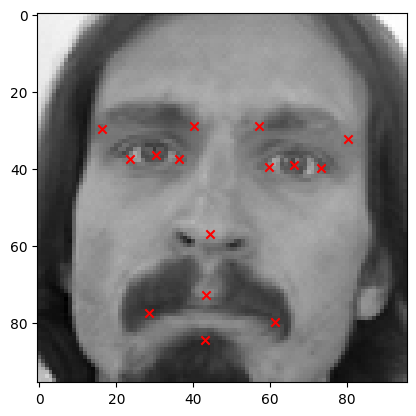

In [53]:
show_image(images[0], targets[0])
# hello